In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from pandas.tseries.offsets import MonthEnd
import plotting 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
from scipy.stats import kruskal 
from scikit_posthocs import posthoc_dunn
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import matplotlib.patches as mpatches
from matplotlib import colors

In [4]:
from os import path
with open(path.expanduser("~") + "/sys_specific.json") as file: 
    params = json.load(file)
_HOME_ = params["home"] + "/PHD"
import modify_dataset

# Basics variables and parameters

In [5]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])

In [6]:
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params

In [7]:
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)

In [8]:
phyto_abund_simplified["id"] = pd.Categorical(phyto_abund_simplified["id"], categories = ordered_id, ordered = True)

In [9]:
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)

In [10]:
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)

In [11]:
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]

In [12]:
transects_info = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

## Filtering protocol

In [9]:
# discarding stations having less than 9 samples
minimum_samples = 9
indices_enough_samples = phyto_abund_simplified[["id", "Date"]].drop_duplicates().groupby("id").count().query("Date > @minimum_samples").index

In [10]:
# removing samples having less than n taxa
minimunm_taxa = 5
indices_minimum_taxa = phyto_abund_simplified.loc[:, ["id", "Date", "Taxon"]].groupby(["id", "Date"]).count().query("Taxon > @minimunm_taxa").index

# Overall Abundance level


## by region

/tmp/ipykernel_5553/464258934.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
/tmp/ipykernel_5553/464258934.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);


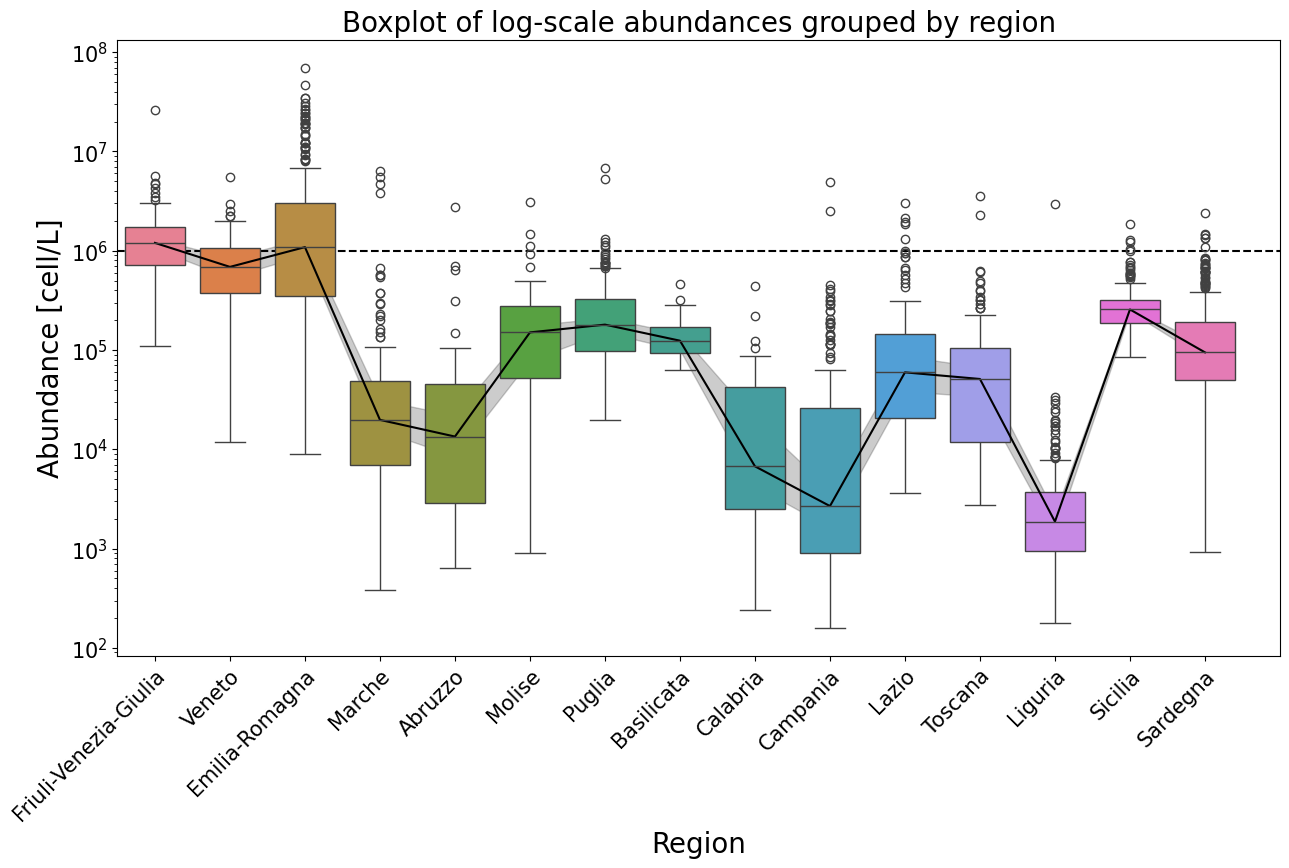

In [16]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
ax.hlines(10**6, -0.5, 15, colors="k", linestyles="dashed")
sns.boxplot(
    phyto_abund_simplified.groupby(["Region", "id", "Date"], observed = True).sum("Num_cell_l").loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    hue = "Region",
    ax = ax
)
sns.lineplot(
    phyto_abund_simplified.groupby(["Region", "id", "Date"], observed = True).sum("Num_cell_l").loc[ordered_regions,:].reset_index(),
    x = "Region", 
    y = "Num_cell_l",
    estimator="median",
    color = "black",
    ax = ax

)
ax.set_xlim(-0.5, 15)
ax.set_yscale("log")
plt.title("Boxplot of log-scale abundances grouped by region", size = 20)
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel(xlabel = "Region", fontsize = 20)
ax.set_yticklabels(labels = ax.get_yticklabels(), fontsize = 15);
ax.set_ylabel("Abundance [cell/L]", fontsize = 20)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_abund_by_region.png",bbox_inches='tight')

In [ ]:
bounds = [0, 0.05, 1]
cm = cmaps.get_cmap("magma").resampled(len(bounds)-1)
norm = mpl.colors.BoundaryNorm(bounds, len(bounds))
p_values = posthoc_dunn(phyto_abund_simplified.groupby(["Region", "id", "Date"], observed = True).sum("Num_cell_l").reset_index(), group_col = "Region", val_col = "Num_cell_l", p_adjust = "bonferroni")
p_values = p_values.loc[ordered_regions]
fig, ax = plt.subplots(1,1, figsize=(13, 11))
sns.heatmap(p_values, 
            ax = ax, cmap = cm, norm = norm, linewidth = 0.5, linecolor = "grey"
                    )
cbar = ax.collections[0].colorbar
cbar.set_label("P-value",size=15)
plt.title("P-values of the post-hoc pairwise Dunn's tests")
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/P_val_Dunn__region.png")

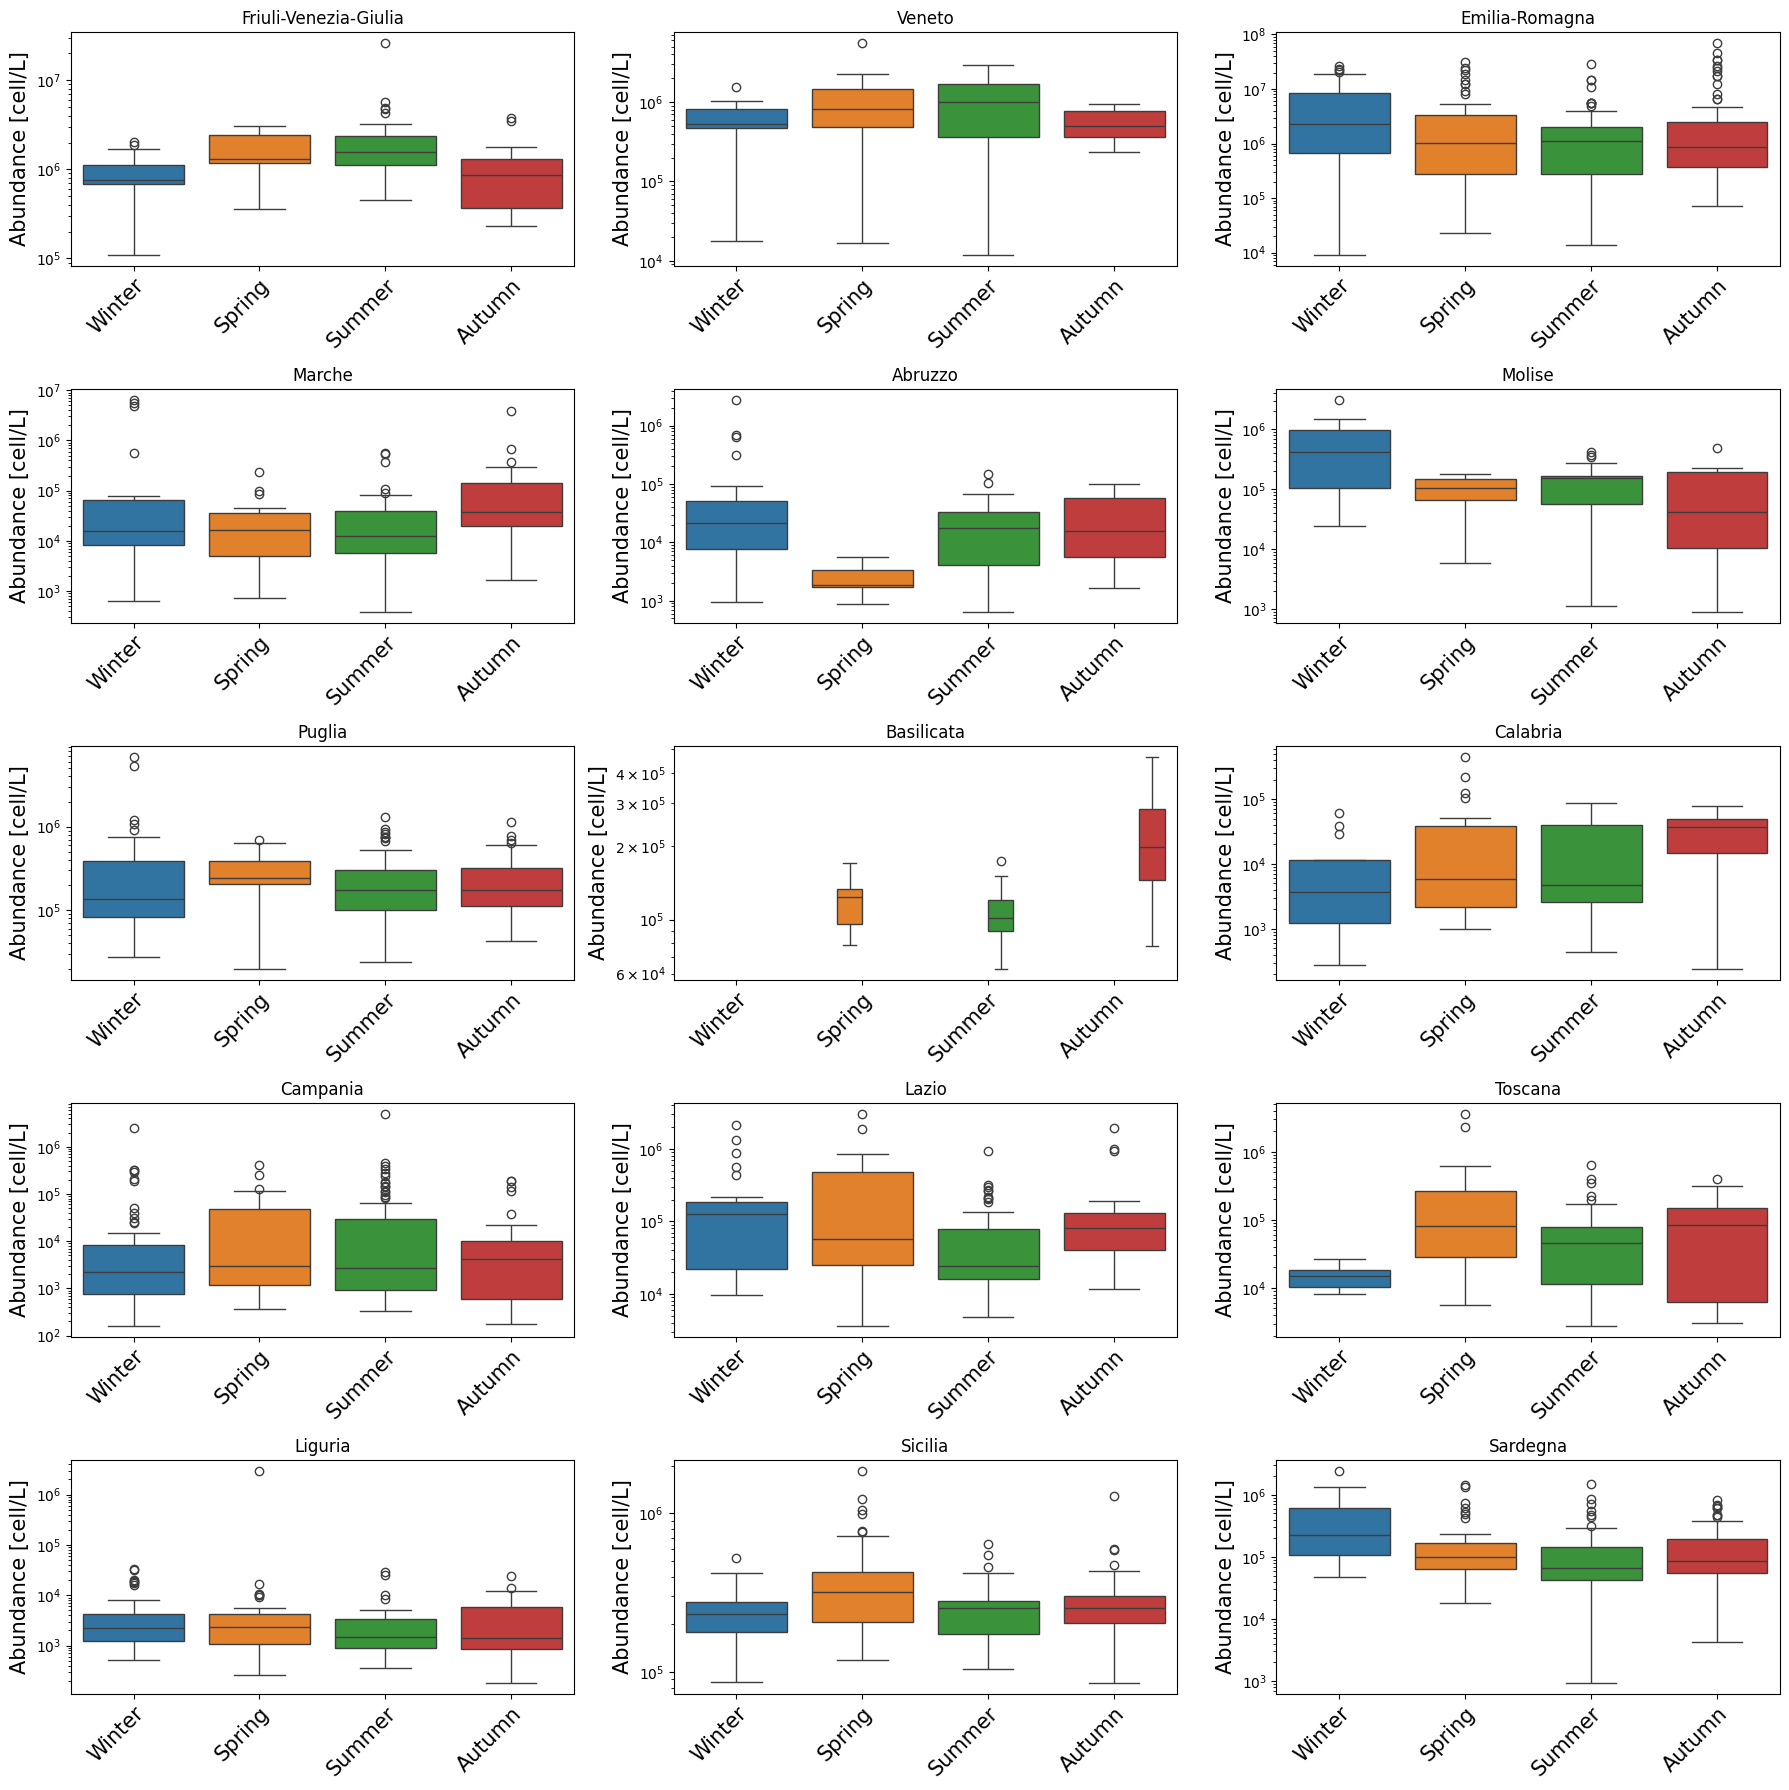

In [27]:
fig, axs = plt.subplots(5, 3, figsize=(18, 18))
axs = axs.flatten()

for ax, (region, df_region) in zip(axs, phyto_abund_simplified.groupby("Region", observed=True)):
    sns.boxplot(
        df_region.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : "sum", "Season" : "first"}).reset_index(),
        x = "Season",
        y = "Num_cell_l",
        hue = "Season",
        ax = ax
    )
    n_samples = df_region.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(region)
    ax.set_yscale("log")
    ax.set_xlabel("")
    ax.set_ylabel("Abundance [cell/L]", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_by_season_per_region.png")

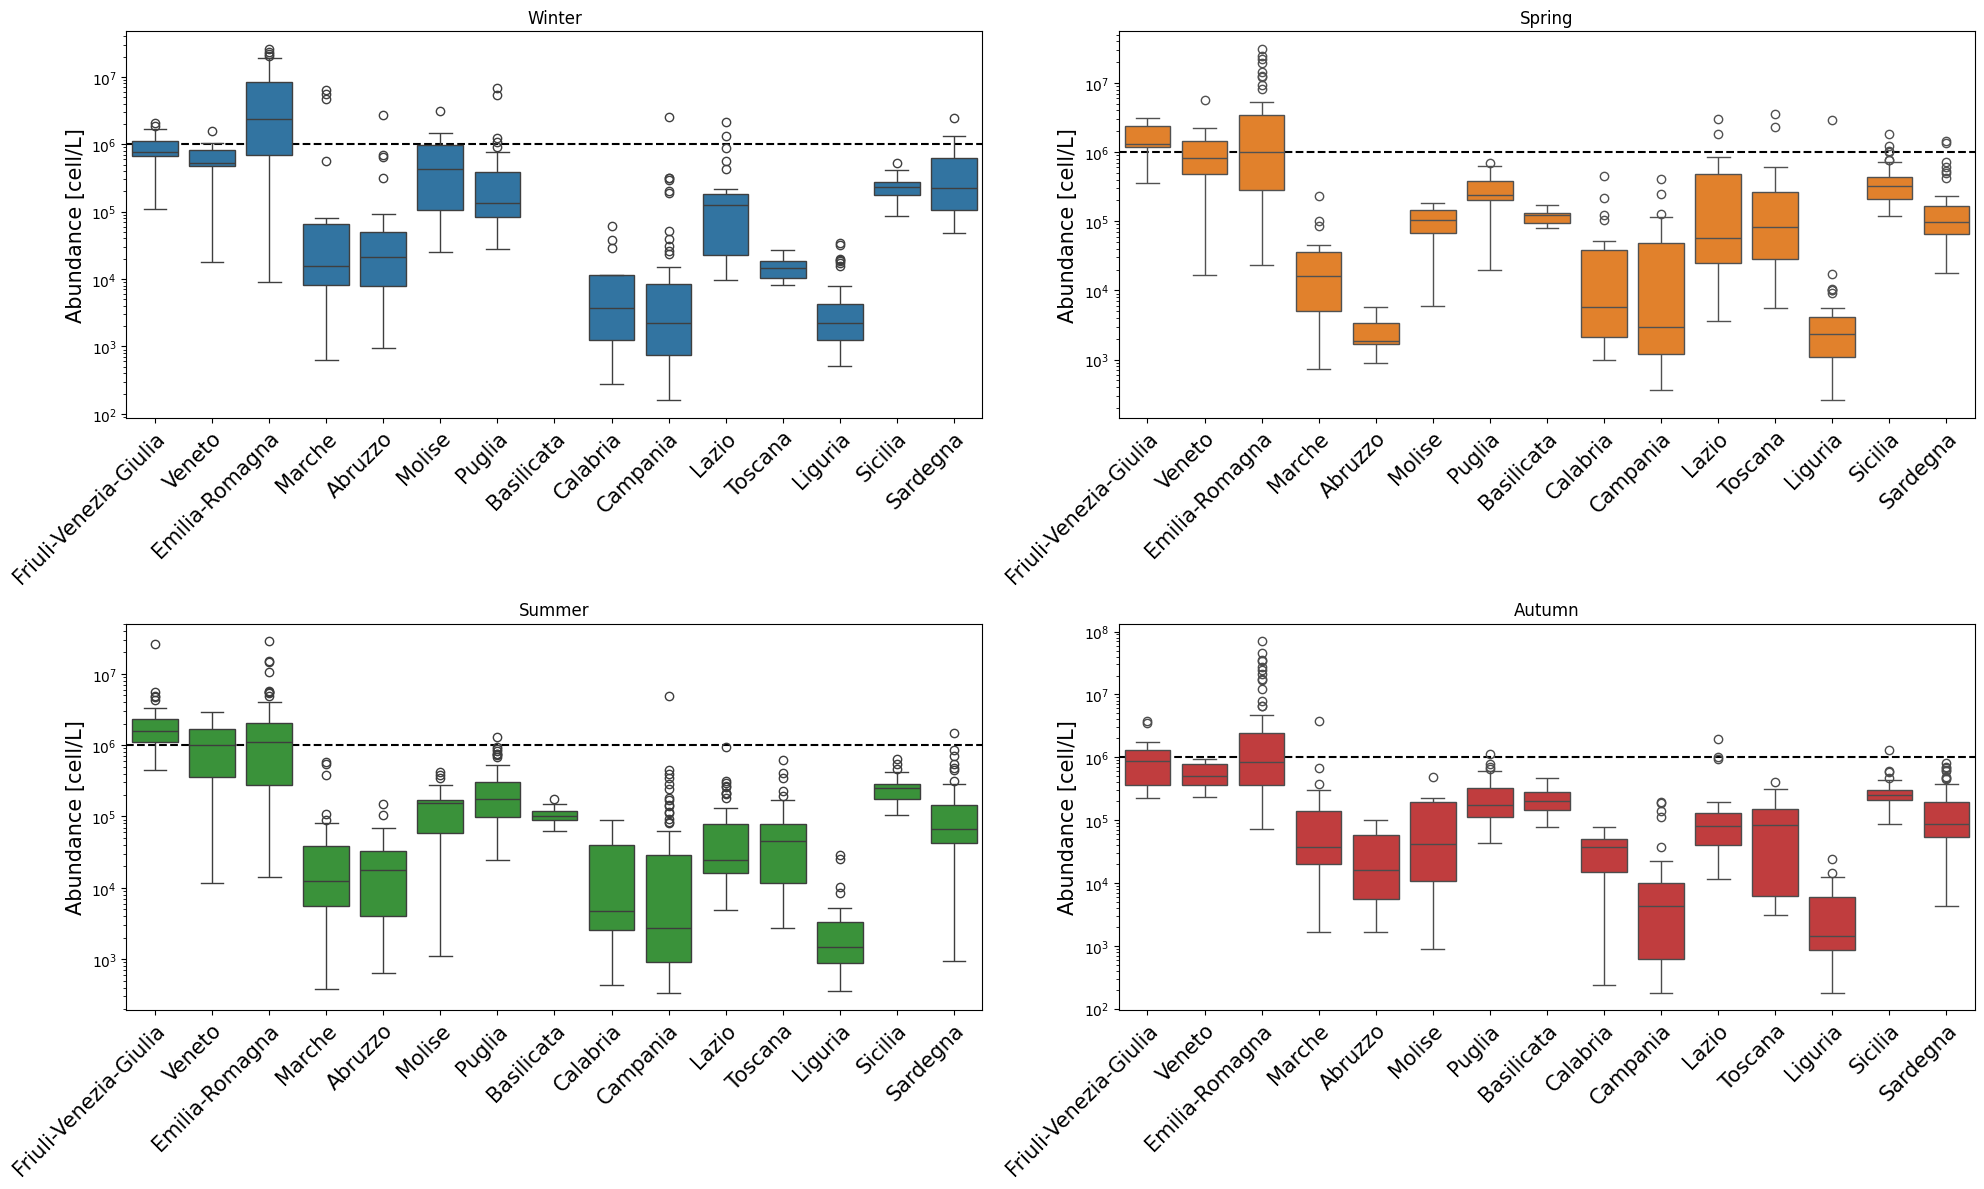

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()

palette = sns.color_palette("tab10", n_colors = 4)
colors = dict(zip(seasons, palette))
for ax, (season, df_season) in zip(axs, phyto_abund_simplified.groupby("Season", observed=True)):
    ax.hlines(10**6, -0.5, 15, colors="k", linestyles="dashed")
    sns.boxplot(
        df_season.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : "sum", "Region" : "first"}).reset_index(),
        x = "Region",
        y = "Num_cell_l",
        color = colors[season],
        ax = ax
    )
    #n_samples = df_season.groupby("Season", observed = True).agg({"id" : "nunique"}).reset_index()
    ax.set_title(season)
    ax.set_yscale("log")
    ax.set_xlabel("")
    ax.set_ylabel("Abundance [cell/L]", size = 15)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_by_season.png", bbox_inches='tight')

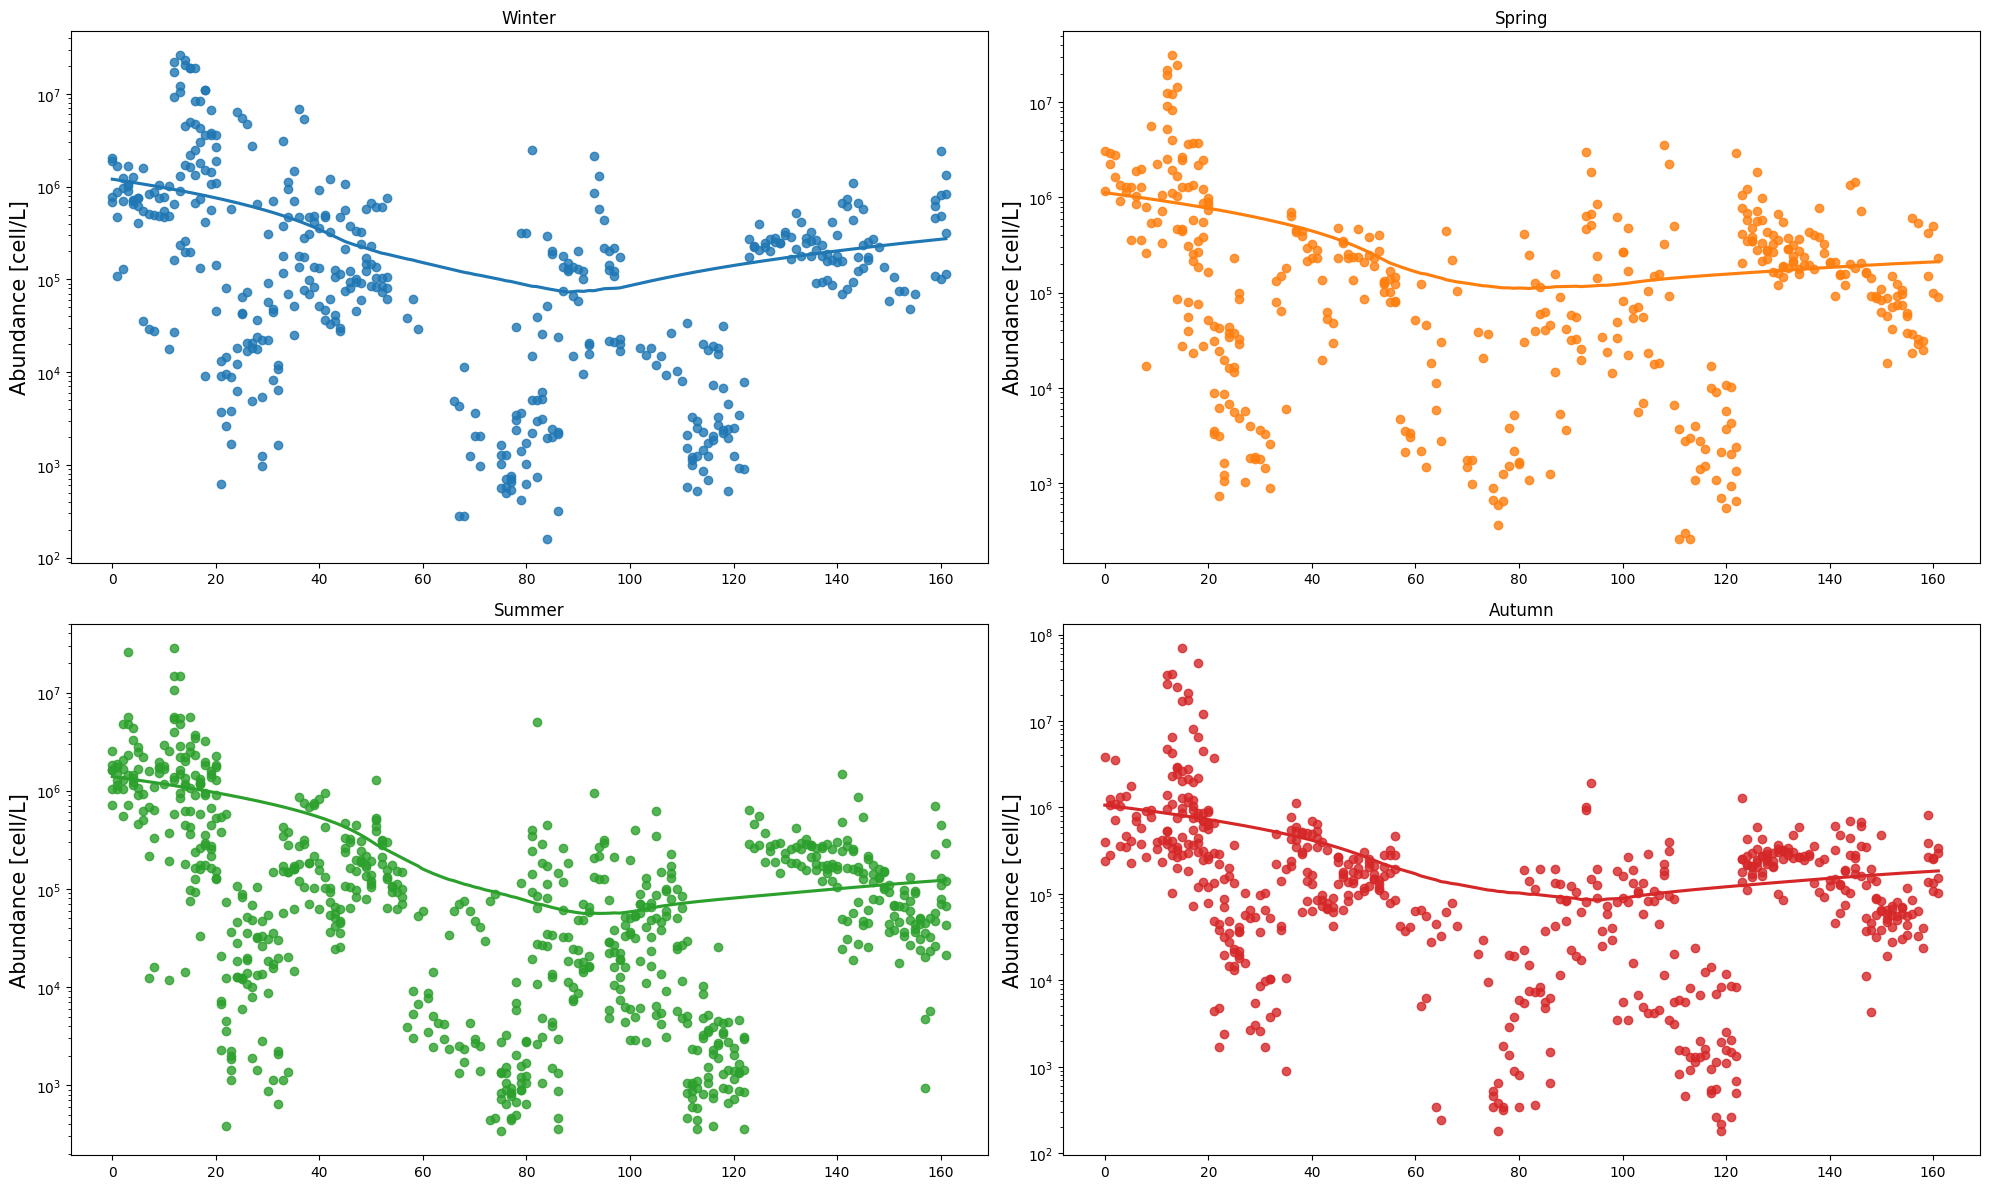

In [79]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()

palette = sns.color_palette("tab10", n_colors = 4)
colors = dict(zip(seasons, palette))
for ax, (season, df_season) in zip(axs, phyto_abund_simplified.groupby("Season", observed=True)):
    df_season["id"] = list(map(lambda x: ordered_id.index(x), df_season["id"]))
    sns.regplot(
        data = df_season.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : "sum"}).reset_index(),
        x = "id",
        y = "Num_cell_l",
        color = colors[season],
        lowess=True,
        ax = ax
    )
    ax.set_title(season)
    ax.set_yscale("log")
    ax.set_xlabel("")
    ax.set_ylabel("Abundance [cell/L]", size = 15)
    #ax.set_xticks(ax.get_xticks())
    #ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_by_season_per_season.png")

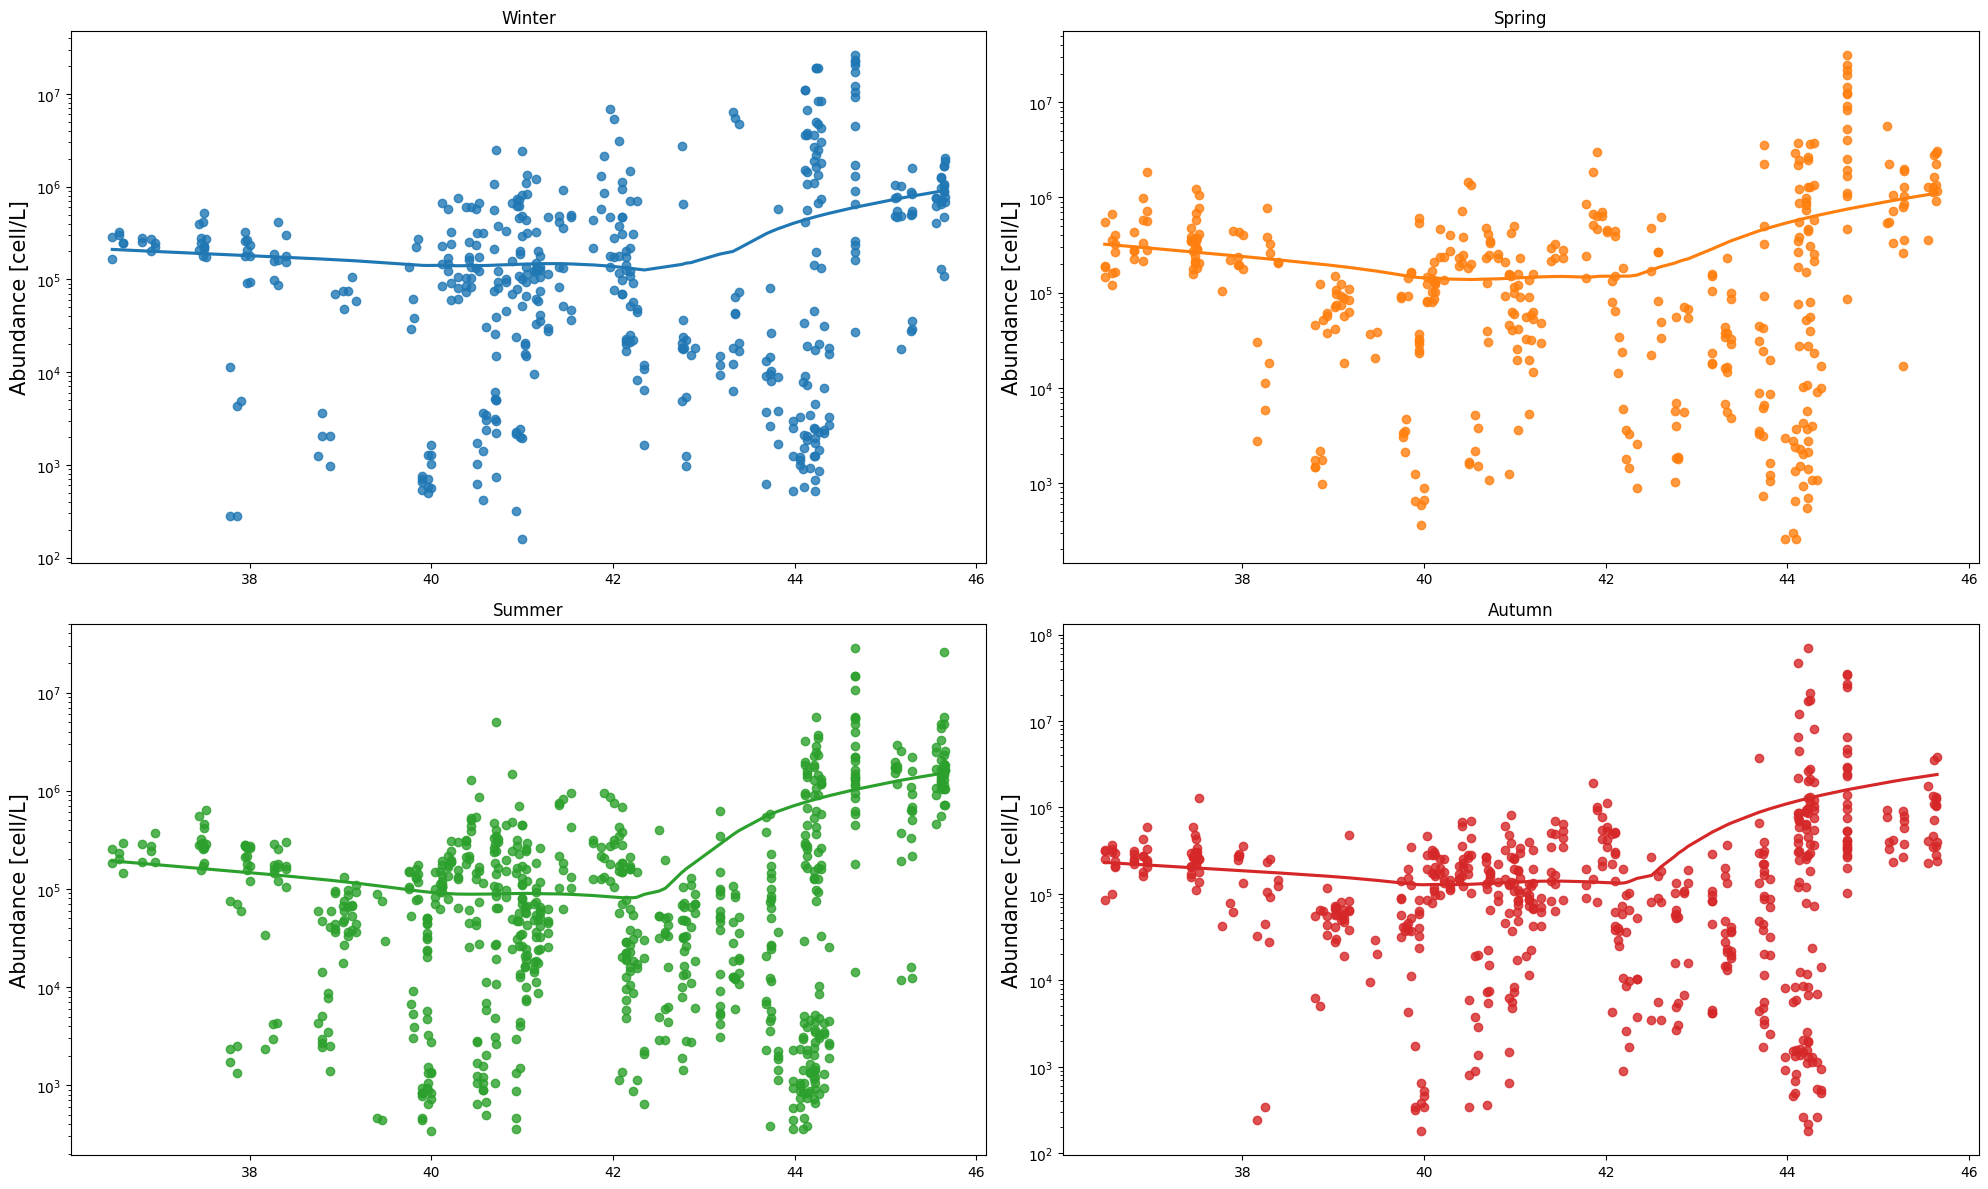

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()

palette = sns.color_palette("tab10", n_colors = 4)
colors = dict(zip(seasons, palette))
for ax, (season, df_season) in zip(axs, phyto_abund_simplified.groupby("Season", observed=True)):
    sns.regplot(
        data = df_season.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : "sum", "Latitude" : "first"}).reset_index(),
        x = "Latitude",
        y = "Num_cell_l",
        color = colors[season],
        lowess=True,
        ax = ax
    )
    ax.set_title(season)
    ax.set_yscale("log")
    ax.set_xlabel("")
    ax.set_ylabel("Abundance [cell/L]", size = 15)
    #ax.set_xticks(ax.get_xticks())
    #ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_by_season_per_season.png")

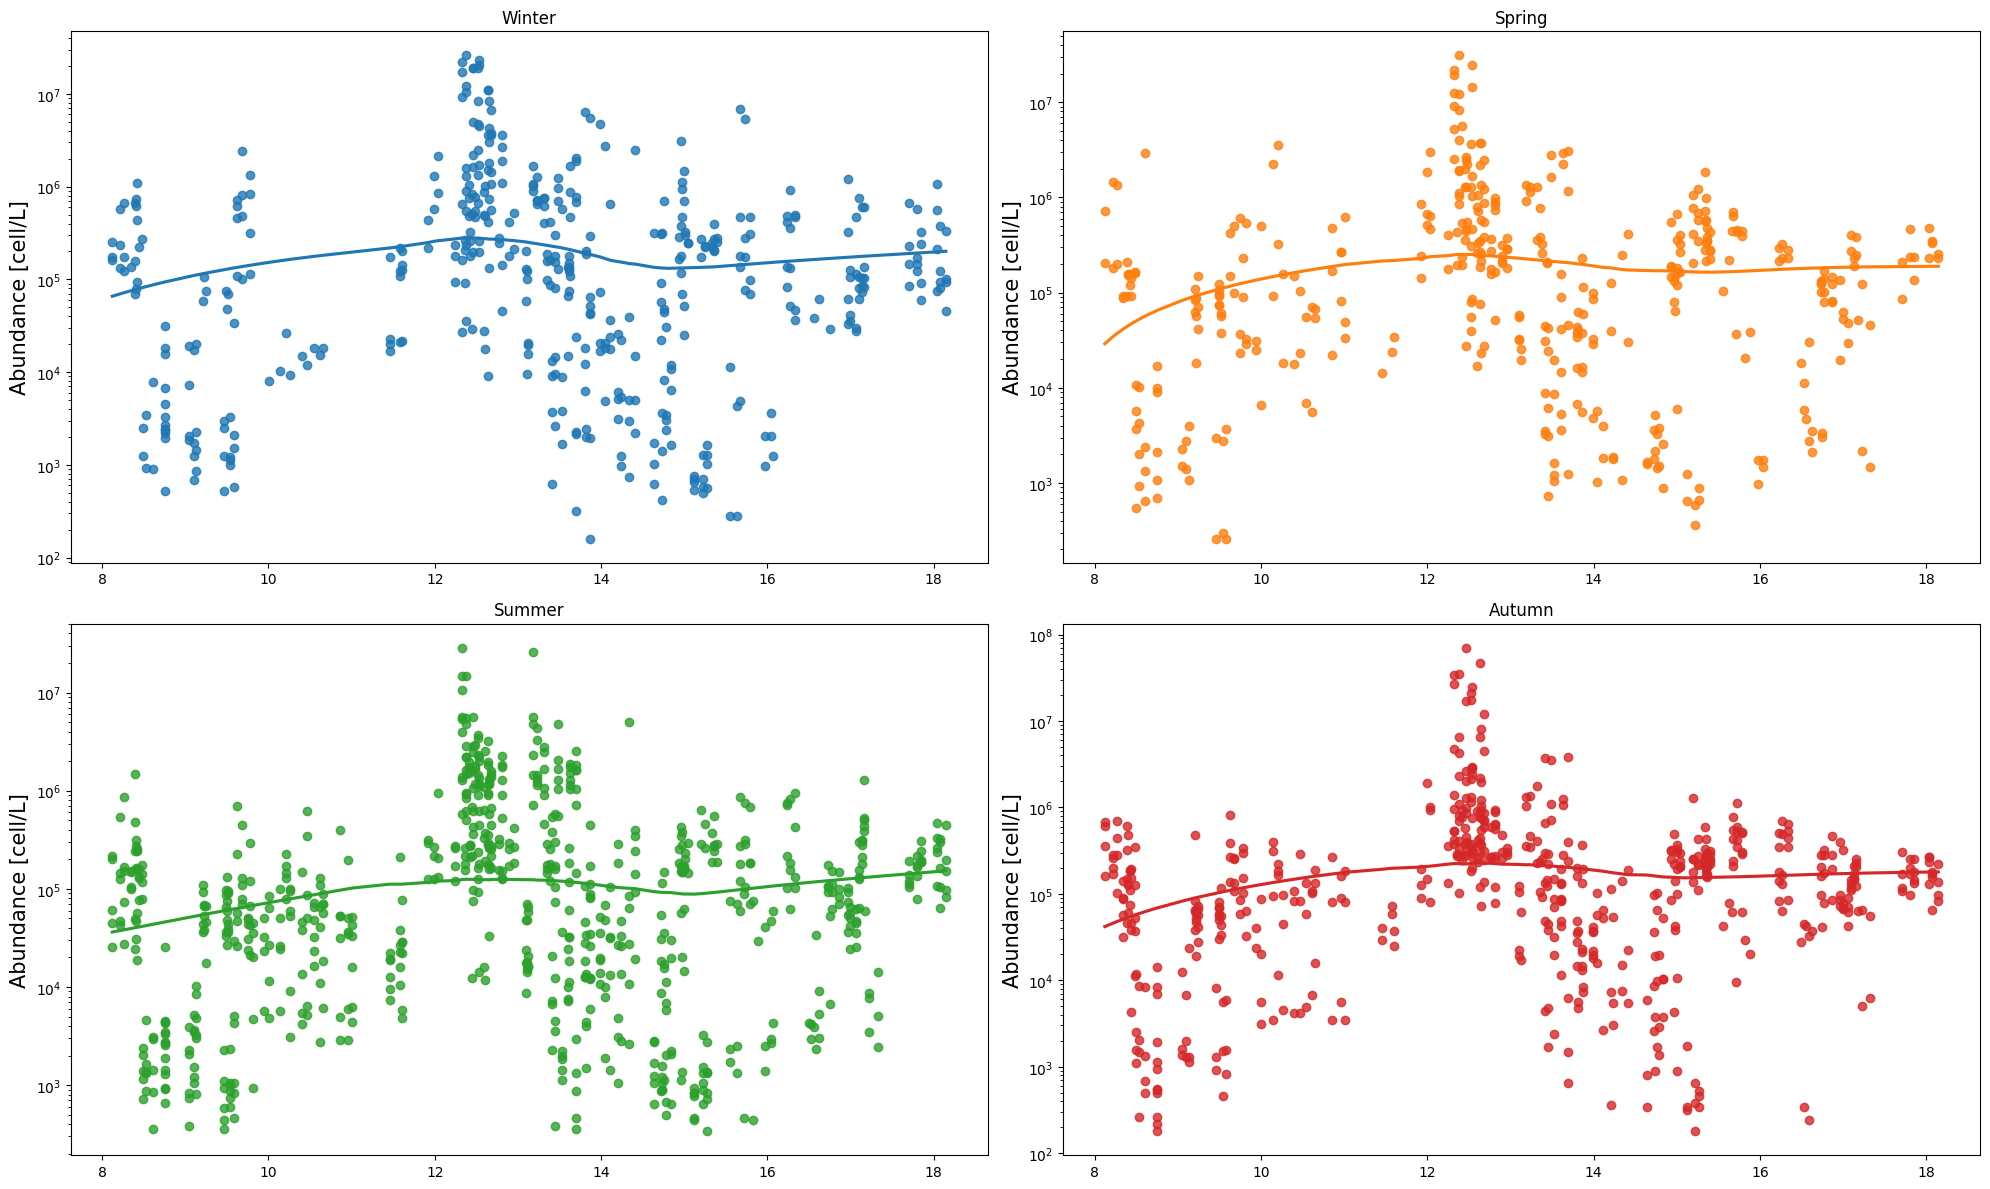

In [82]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()

palette = sns.color_palette("tab10", n_colors = 4)
colors = dict(zip(seasons, palette))
for ax, (season, df_season) in zip(axs, phyto_abund_simplified.groupby("Season", observed=True)):
    sns.regplot(
        data = df_season.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : "sum", "Longitude" : "first"}).reset_index(),
        x = "Longitude",
        y = "Num_cell_l",
        color = colors[season],
        lowess=True,
        ax = ax
    )
    ax.set_title(season)
    ax.set_yscale("log")
    ax.set_xlabel("")
    ax.set_ylabel("Abundance [cell/L]", size = 15)
    #ax.set_xticks(ax.get_xticks())
    #ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/boxplot_by_season_per_season.png")

In [71]:
phyto_abund_simplified.groupby(["Region", "id", "Date"], observed = True).agg({"Num_cell_l" : "sum", "Season" : "first"}).reset_index().groupby(["Region", "Season"], observed = True).agg({"Num_cell_l" : "count"})

Num_cell_l
Region                Season            
Friuli-Venezia-Giulia Winter          24
                      Spring          12
                      Summer          36
                      Autumn          18
Veneto                Winter          18
                      Spring          16
                      Summer          24
                      Autumn          12
Emilia-Romagna        Winter          54
                      Spring          54
                      Summer          81
                      Autumn          81
Marche                Winter          24
                      Spring          30
                      Summer          36
                      Autumn          36
Abruzzo               Winter          24
                      Spring          12
                      Summer          30
                      Autumn          21
Molise                Winter          12
                      Spring           6
                      Summer          18
                      Autumn           9
Puglia                Winter          72
                      Spring          36
                      Summer          84
                      Autumn          78
Basilicata            Spring          12
                      Summer          12
                      Autumn          12
Calabria              Winter          13
                      Spring          25
                      Summer          38
                      Autumn          19
Campania              Winter          48
                      Spring          24
                      Summer          72
                      Autumn          36
Lazio                 Winter          36
                      Spring          24
                      Summer          53
                      Autumn          29
Toscana               Winter           9
                      Spring          27
                      Summer          69
                      Autumn          39
Liguria               Winter          42
                      Spring          30
                      Summer          66
                      Autumn          42
Sicilia               Winter          42
                      Spring          60
                      Summer          51
                      Autumn          63
Sardegna              Winter          39
                      Spring          50
                      Summer          97
                      Autumn          83

In [70]:
p_values = {}
posthoc = {}
for (region, df_region) in phyto_abund_simplified.groupby("Region", observed=True):
    df_region = df_region.groupby(["id", "Date"], observed = True).agg({"Num_cell_l" : "sum", "Season" : "first"}).reset_index()
    groups = [df_region.query("Season == @season")["Num_cell_l"].values for season in df_region["Season"].unique()]
    p_values[region] = kruskal(*groups).pvalue
    if p_values[region] < 0.05:
        posthoc[region] = posthoc_dunn(df_region, group_col="Season", val_col = "Num_cell_l", p_adjust = "bonferroni").unstack(
            ).reset_index().assign(pair = lambda x : x["level_0"].astype(str) + "-" + x["level_1"].astype(str)).drop(["level_0", "level_1"], axis = 1).set_index("pair").T
        posthoc[region].index = [region]
posthoc = pd.concat(posthoc.values())
p_values = pd.DataFrame(index = p_values.keys(), data = p_values.values(), columns = ["P-value"])
p_values.merge(posthoc, left_index = True, right_index = True, how = "outer").loc[ordered_regions, :].to_csv(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/P_val_Dunn__season.csv")

/home/alberto/miniconda3/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_lens = x.groupby(_group_col)[_val_col].count()
/home/alberto/miniconda3/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:360: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x_ranks_avg = x.groupby(_group_col)['ranks'].mean()
/home/alberto/miniconda3/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:357: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beh

## Contribution to the abundance for each cathegory

### Pie chart

In [ ]:
colours = {'Genus': 'C0', 'Species': 'C1', 'Unknown': 'C3', 'Higher cat.': 'C2'}
fig, axs = plt.subplots(5, 3, figsize=(13, 13)) #5
axs = axs.flat

abund_aggregated = phyto_abund_simplified.groupby(["Region", "Det_level"], observed = True).agg({"Num_cell_l" : "sum", "Taxon" : "nunique"}).reset_index(
    ).groupby("Region", observed = True)

for i, ((group_name, group), ax) in enumerate(zip(abund_aggregated, fig.axes)): 
    labels = []
    for i, j in group[["Det_level", "Taxon"]].to_numpy(): 
        if i != "Unknown":
            labels += [f"{i} ({j})"]
        else: 
            labels += [f"{i}"]
    ax.pie(group["Num_cell_l"].to_numpy(), labels = labels, colors= [colours[key] for key in group["Det_level"].to_numpy()], autopct='%.2f')
    ax.set_title(group_name)
    ax.set_aspect("auto")
fig.suptitle("Contribution to the abundance of each taxonomic level (surface level)", y = 1.005, fontsize = 15)
plt.tight_layout()
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Category_contribution_surf.png", bbox_inches='tight')

### bar plots

In [ ]:
### OBSOLETE ###
colours = {'Genus': 'C0', 'Species': 'C1', 'Unknown': 'C3', 'Higher cat.': 'C2'}

fig = plt.figure(figsize=(19, 13))
gs = fig.add_gridspec(2,15, height_ratios = [0.8, 3])

#data creation 
df = phyto_abund_simplified.groupby(["Region", "Det_level"], observed  = True).agg({"Num_cell_l" : "sum", "Taxon" : "nunique"}).reset_index()
samples = phyto_abund_simplified[["Region", "id", "Date"]].groupby(["Region", "id"], observed  = True).nunique().reset_index().groupby("Region", observed  = True).sum(numeric_only=True).rename(columns={"Date" : "Num_cell_l"})
df["Num_cell_l"] = df[["Region", "Num_cell_l"]].set_index("Region").div(samples).loc[:, "Num_cell_l"].to_numpy()
df["Region"] = pd.Categorical(df["Region"], ordered=True, categories=ordered_regions)
df["Det_level"] = pd.Categorical(df["Det_level"], ordered=True, categories=["Genus", "Species", "Unknown", "Higher cat."])
samples = phyto_abund_simplified[["Region", "id", "Date"]].groupby(["Region", "id"], observed=True).nunique().reset_index().groupby("Region").sum(numeric_only=True).rename(columns={"Date" : "Num_cell_l"})
df.rename(columns={"Det_level" : "Taxonomic level"}, inplace=True)

#bar plots 
ax = fig.add_subplot(gs[1,:])
bars = sns.barplot(df.groupby("Region", observed=True).sum(numeric_only=True).reset_index(), x = "Region", y = "Num_cell_l", ax = ax, color= "white", width = 0.8, linewidth = 0.2, edgecolor = "k")
for bar in bars.patches: 
    bar.set_hatch("//")
sns.barplot(df, x="Region", y="Num_cell_l", hue = "Taxonomic level", palette = colours, ax = ax, width = 0.8)
ax.set_yscale("log")
ax.set_ylabel("Mean abundance per sample [cell/L]", size = 15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15);
ax.set_xlabel("")

#pie plots
for i, region in enumerate(ordered_regions): 
    ax = fig.add_subplot(gs[0, i])
    df_region = df.query("Region == @region")
    ax.pie(df_region["Num_cell_l"].to_numpy(), autopct='%1.1f%%', colors = [colours[key] for key in df_region["Taxonomic level"].to_numpy()])
    #ax.axis("equal")

plt.tight_layout()
plt.suptitle("Contribution to the abundance of each taxonomic level", fontsize = 15)
plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/Cat_contribution_barplot.png")

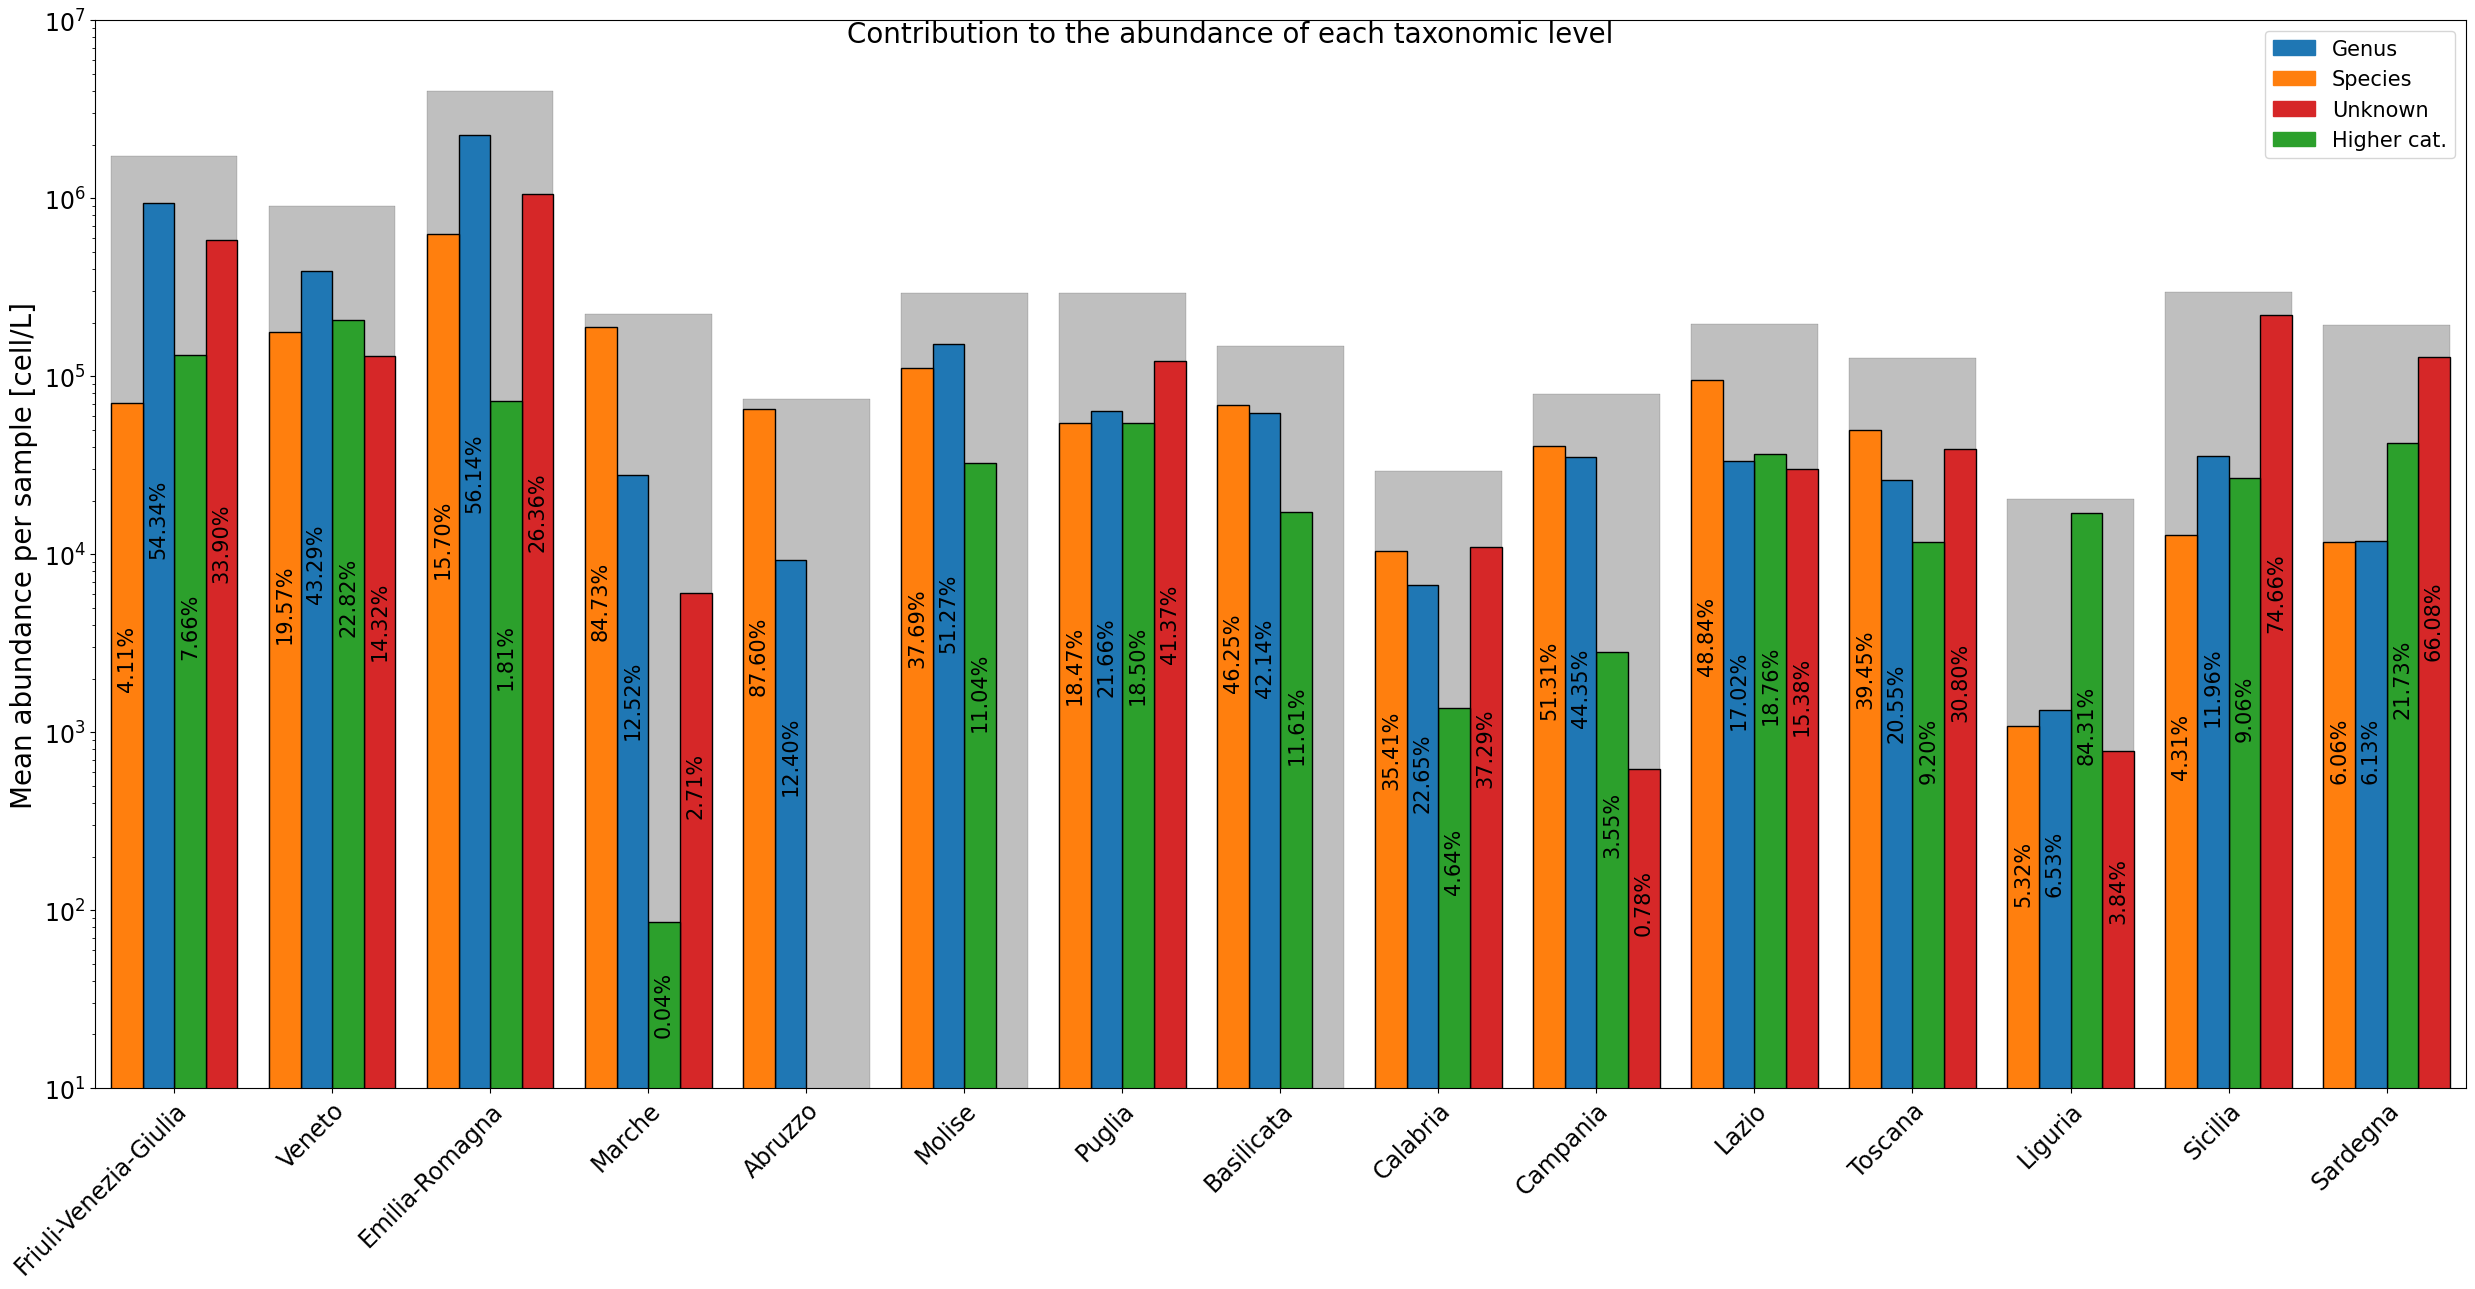

In [26]:
fig, ax = plt.subplots(1,1, figsize=(25, 13))

colours = {'Genus': 'C0', 'Species': 'C1', 'Unknown': 'C3', 'Higher cat.': 'C2'}
# data creation
df = phyto_abund_simplified.groupby(["Region", "Det_level"], observed=True).agg({"Num_cell_l": "sum", "Taxon": "nunique"}).reset_index()
samples = phyto_abund_simplified[["Region", "id", "Date"]].groupby(["Region", "id"], observed=True).nunique().reset_index().groupby("Region", observed=True).sum(numeric_only=True).rename(columns={"Date": "Num_cell_l"})
df["Num_cell_l"] = df[["Region", "Num_cell_l"]].set_index("Region").div(samples).loc[:, "Num_cell_l"].to_numpy()
df["Region"] = pd.Categorical(df["Region"], ordered=True, categories=ordered_regions)
df["Det_level"] = pd.Categorical(df["Det_level"], ordered=True, categories=["Species", "Genus", "Higher cat.", "Unknown"])
df.rename(columns={"Det_level": "Taxonomic level"}, inplace=True)


#hist plots
sns.histplot(df, x="Region", hue="Taxonomic level", weights="Num_cell_l", palette=colours, multiple="dodge", shrink=0.8, discrete=True, legend=False, alpha = 1)
ax.set_yscale("log")

abunds = df[["Region", "Taxonomic level","Num_cell_l"]]
df = df.pivot_table(
        index="Region", columns="Taxonomic level", values="Num_cell_l"
    ).fillna(0).apply(lambda x: x / np.sum(x) * 100, axis=1).stack().reset_index().rename(columns={0: "Percentage"})

df["Taxonomic level"] = pd.Categorical(df["Taxonomic level"], ordered=True, categories=["Species", "Genus", "Higher cat.", "Unknown"])
df = df.merge(abunds, on=["Region", "Taxonomic level"])

# Add annotations
filled_patches = list(filter(lambda x : x.get_height() > 0, ax.patches))
for p, values in zip(sorted(filled_patches, key=lambda x: x.get_x()), df["Percentage"].to_numpy()):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    #option 1 10 ** (np.log10(height) / 2)
    ax.annotate(text=f"{values:.2f}%", xy=(x + width / 2,   10 ** (2 * np.log10(height) / 3)), ha='center', va='bottom', rotation = 90, size = 15)

# bar plots
bars = sns.barplot(df.groupby("Region", observed=True).sum(numeric_only=True).reset_index(), x = "Region", y = "Num_cell_l", color= "gray", width = 0.8, linewidth = 0.2, edgecolor = "k", zorder = 0, alpha = 0.5, ax = ax)

ax.set_ylim(10**2, 5 * 10**6)
ax.set_ylabel("Mean abundance per sample [cell/L]", size=20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", ha="right", fontsize=17)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize=17)
ax.set_xlabel("")
ax.set_ylim(10, 10**7)
# legend
handles = [mpatches.Patch(color=colours[name], label=name) for name in colours.keys()]
ax.legend(handles=handles, loc = "best", fontsize = 15)


plt.tight_layout()
plt.suptitle("Contribution to the abundance of each taxonomic level", fontsize=20)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/Cat_contribution_barplot.png")

In [76]:
phyto_abund_simplified.groupby(["Region", "Det_level"], observed=True).agg({"Num_cell_l": "sum", "Taxon": "nunique"}).reset_index().pivot_table(index = "Det_level", columns = "Region", values = "Taxon").fillna(0).to_csv(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/Cat_contribution.csv")

### By Class

### by Region

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12)) #5

threshold = 0.95
df_abund_by_class = pd.DataFrame({
    "Region" : [], 
    "Class" : [], 
    "Num_cell_l" : []
})
for (region, df_region) in phyto_abund_simplified.groupby("Region", observed=True):
    df = df_region.loc[:, ["Class", "Taxon", "Num_cell_l"]]
    df.loc[df["Class"] == "nan", "Class"] = df.loc[df["Class"] == "nan", "Taxon"]
    df = df[["Class", "Num_cell_l"]].groupby("Class").sum().sort_values("Num_cell_l", ascending = False).reset_index()
    df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
    idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
    df.iloc[idx:,0] = "else"
    df = df.groupby("Class").sum(numeric_only = True).reset_index()
    df["Region"] = region
    df_abund_by_class = pd.concat([df_abund_by_class, df])

df_abund_by_class["Region"] = pd.Categorical(df_abund_by_class["Region"], ordered=True, categories=ordered_regions)
all_names = df_abund_by_class["Class"].unique()
num_colors = all_names.size
colors = plt.get_cmap("turbo")(np.linspace(0, 1, num_colors))
color_dict = {name: color for name, color in zip(all_names, colors)}
color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]
color_dict["Other phytoplankton"] = [0.62, 0.62, 0.62, 1]

sns.histplot(
    df_abund_by_class.pivot_table(
        index="Region", columns="Class", values="Num_cell_l"
    ).fillna(0).apply(lambda x: x / np.sum(x), axis=1).stack().reset_index().rename(columns={0: "Percentage"}),
    x='Region',
    hue='Class',
    weights='Percentage',
    multiple='stack',
    discrete = True,
    ax=ax,
    palette=color_dict,
    legend=False,
    shrink = 0.8  # Adjust the binwidth to widen the distance between bars
    )
    
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height == 0:
        continue
    x, y = p.get_xy()
    ax.annotate(f'{height:.2%}', (x + width/2, y + height/2), ha='center', va='center', fontsize=12, color='black')

ax.set_xlabel("")
ax.set_ylabel("Percentage of abundance", size = 15)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode = "anchor", ha = "right", fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
ax.set_ylim(0,1.05)
handles = [mpatches.Patch(color=color_dict[name], label=name) for name in all_names]
fig.legend(handles=handles, bbox_to_anchor=(0, -.07, 1, 0.101), loc='center', ncol=4)
plt.tight_layout()
#plt.savefig(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots/Abund_levels/Class_contribution_bar.png", bbox_inches='tight')

In [49]:
df_region.loc[df_region["Class"] == "nan", "Class"] = df_region.loc[df_region["Class"] == "nan", "Taxon"]

threshold = 0.95
class_abund = pd.DataFrame({
"Class" : [],
"Num_cell_l" : [],
"Cumsum_percent" : [],
"Season"  : []
})
for season in ["Winter", "Spring", "Summer", "Autumn"]: 
    df = df_region.query("Season == @season")[["Class", "Num_cell_l"]].groupby("Class").sum(numeric_only = True).sort_values("Num_cell_l", ascending = False).reset_index()
    df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
    idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
    df.iloc[idx:,0] = "else"
    df = df.groupby("Class").sum(numeric_only = True).reset_index()
    df["Season"] = season
    class_abund = pd.concat([class_abund, df])
samples = df_region[["Season", "id", "Date"]].drop_duplicates().groupby("Season", observed  = True).count().rename(columns={"id" : "Num_cell_l"})
class_abund.set_index(["Season", "Class"], inplace = True)
class_abund["Num_cell_l"] = class_abund["Num_cell_l"].div(samples["Num_cell_l"])
class_abund = class_abund.reset_index()
class_abund["Season"] = pd.Categorical(class_abund["Season"], categories = ["Winter", "Spring", "Summer", "Autumn"], ordered = True)

### Season

In [10]:
description = "barplots of abundaces per season with the the composition of the abundances, added common palette and divided by n samples, adjusted colors\n \
    adjusted colors,  and showning all classes"

@plotting.make_sim_directory(description)
def abund_and_composition_by_season(file_path, output_dir): 
    
    df_regions = {}
    all_names = set()
    for (region, df_region) in phyto_abund_simplified.groupby("Region", observed = True):
    
        df_region.loc[df_region["Class"] == "nan", "Class"] = df_region.loc[df_region["Class"] == "nan", "Taxon"]

        threshold = 0.95
        class_abund = pd.DataFrame({
        "Class" : [],
        "Num_cell_l" : [],
        "Cumsum_percent" : [],
        "Season"  : []
        })
        relevant_classes = set()
        #get relevant classes
        for season in ["Winter", "Spring", "Summer", "Autumn"]: 
            df = df_region.query("Season == @season")[["Class", "Num_cell_l"]].groupby("Class").sum(numeric_only = True).sort_values("Num_cell_l", ascending = False).reset_index()
            df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
            idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
            relevant_classes = relevant_classes.union(set(df.iloc[:idx,0]))
            df["Season"] = season
            class_abund = pd.concat([class_abund, df])
        class_abund.loc[~class_abund["Class"].isin(relevant_classes), "Class"] = "Else"
        class_abund = class_abund.groupby(["Season", "Class"]).sum(numeric_only = True).reset_index()
        class_abund.loc[class_abund["Class"] == "Other phytoplankton", "Class"] = "Unknown phytoplankton"
        samples = df_region[["Season", "id", "Date"]].drop_duplicates().groupby("Season", observed  = True).count().rename(columns={"id" : "Num_cell_l"})
        class_abund.set_index(["Season", "Class"], inplace = True)
        class_abund["Num_cell_l"] = class_abund["Num_cell_l"].div(samples["Num_cell_l"])
        class_abund = class_abund.reset_index()
        class_abund["Season"] = pd.Categorical(class_abund["Season"], categories = ["Winter", "Spring", "Summer", "Autumn"], ordered = True)
        class_abund = class_abund.merge(class_abund.pivot_table(
                index="Season", columns="Class", values="Num_cell_l"
            ).fillna(0).apply(lambda x: x / np.sum(x) * 100, axis=1).stack().reset_index().rename(columns={0: "Percentage"}), on = ["Season", "Class"])
        all_names = all_names.union(class_abund["Class"].unique())
        df_regions[region] = class_abund
    all_names.remove("Unknown phytoplankton")
    
    
    #creating colormap
    if len(all_names) <= 10:
        cmap = plt.get_cmap("tab10")
    else:   
        cmap = plt.get_cmap("tab20")
    colors = cmap.colors[:len(all_names)]
    color_dict = {name : color for name, color in zip(all_names, colors)}
    color_dict["Unknown phytoplankton"] = [0, 0, 0, 1]
    
    for (region, class_abund) in df_regions.items():
        
        ## create figure
        fig, ax = plt.subplots(1,1, figsize=(15, 10)) 

        ## histplot 
        sns.histplot(class_abund.loc[:, ["Season", "Class", "Num_cell_l"]], x="Season", hue="Class", weights="Num_cell_l", multiple="dodge", palette = color_dict, ax = ax, discrete = True, shrink = 0.8, legend=False)
        ax.set_yscale("log")
        ax.set_xlabel("Season", size = 15)
        ax.set_ylabel("Abundance [cell/L]", size = 15)
        handles = [mpatches.Patch(color=color_dict[name], label=name) for name in class_abund["Class"].unique()]
        ax.legend(handles=handles, loc='best', ncol=2)

        filled_patches = list(filter(lambda x : x.get_height() > 0, ax.patches))
        val_percent = class_abund[["Num_cell_l", "Percentage"]].set_index("Num_cell_l")
        for p in filled_patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            values = val_percent.loc[height, "Percentage"]
            ax.annotate(text=f"{values:.2f}%", xy=(x + width / 2, y + height), ha='center', va='bottom')

        plt.tight_layout()
        plt.title(region, size = 20, loc="center")
        plt.savefig(f"{file_path}/{output_dir}/{region}_abund_composition.png", bbox_inches='tight')
        plt.close()
abund_and_composition_by_season(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels", "Abund_comp_season")

### Liguria without strange cryptophyceae bloom

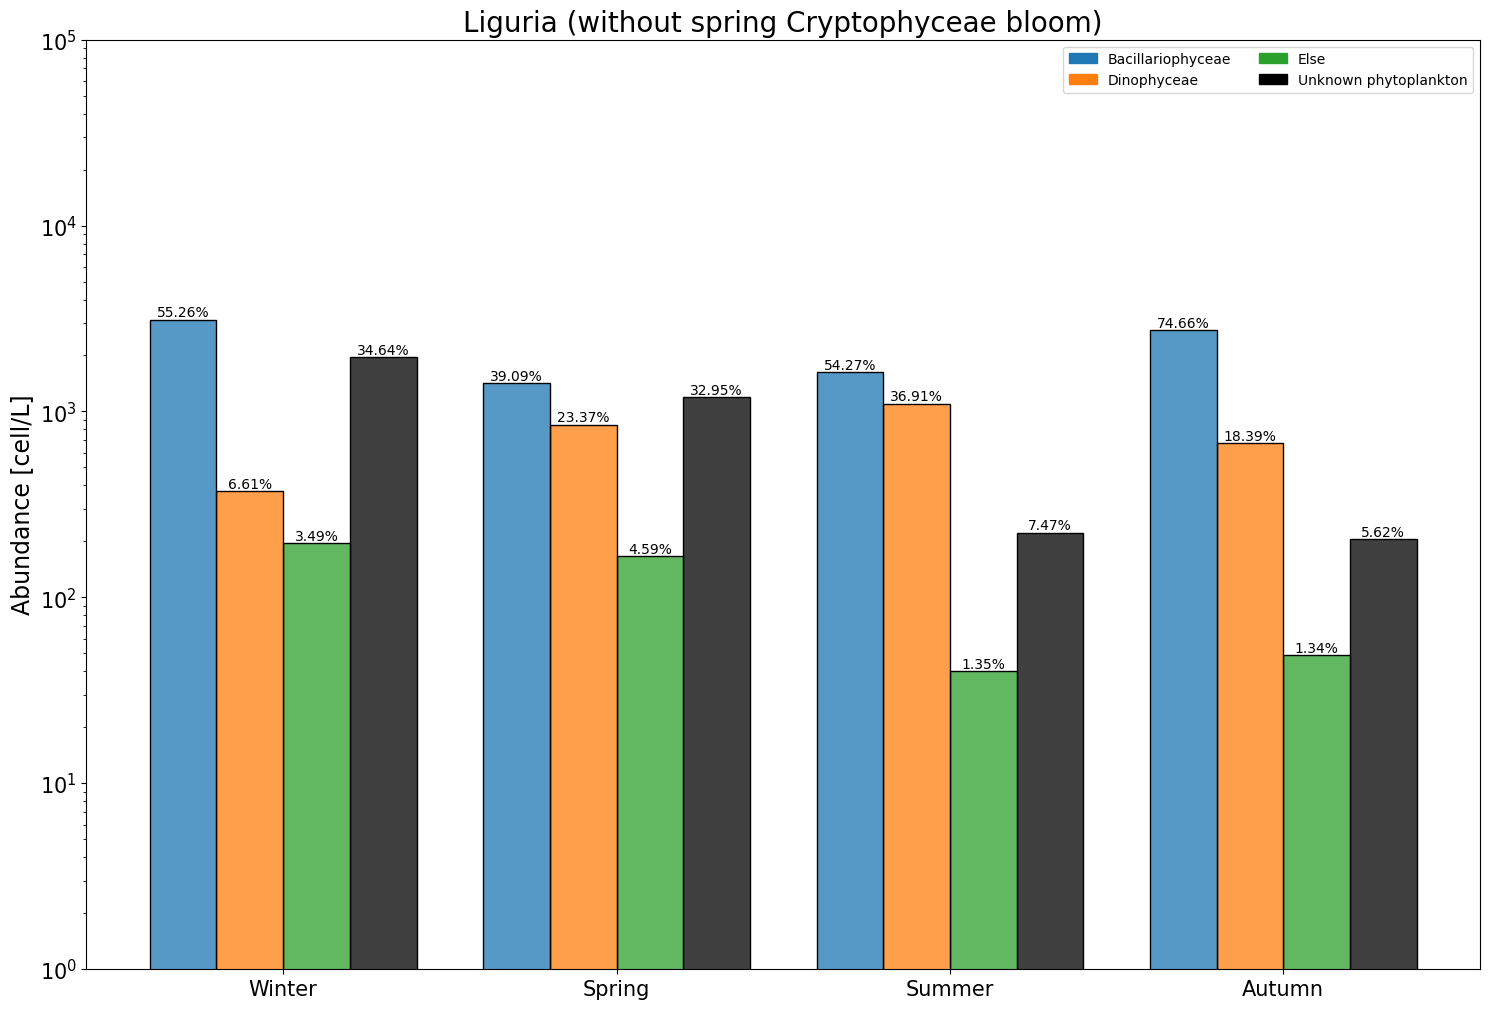

In [15]:
df_region = phyto_abund_simplified.query("Region == 'Liguria'")
df_region = df_region.loc[~((df_region["Date"] == "2017-04-30") & (df_region["id"] == "VAD120")), :]
df_region.loc[df_region["Class"] == "nan", "Class"] = df_region.loc[df_region["Class"] == "nan", "Taxon"]

all_names = set()
df_region.loc[df_region["Class"] == "nan", "Class"] = df_region.loc[df_region["Class"] == "nan", "Taxon"]

threshold = 0.95
class_abund = pd.DataFrame({
"Class" : [],
"Num_cell_l" : [],
"Cumsum_percent" : [],
"Season"  : []
})
relevant_classes = set()
#get relevant classes
for season in ["Winter", "Spring", "Summer", "Autumn"]: 
    df = df_region.query("Season == @season")[["Class", "Num_cell_l"]].groupby("Class").sum(numeric_only = True).sort_values("Num_cell_l", ascending = False).reset_index()
    df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
    idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
    relevant_classes = relevant_classes.union(set(df.iloc[:idx,0]))
    df["Season"] = season
    class_abund = pd.concat([class_abund, df])
class_abund.loc[~class_abund["Class"].isin(relevant_classes), "Class"] = "Else"
class_abund = class_abund.groupby(["Season", "Class"]).sum(numeric_only = True).reset_index()
class_abund.loc[class_abund["Class"] == "Other phytoplankton", "Class"] = "Unknown phytoplankton"
samples = df_region[["Season", "id", "Date"]].drop_duplicates().groupby("Season", observed  = True).count().rename(columns={"id" : "Num_cell_l"})
class_abund.set_index(["Season", "Class"], inplace = True)
class_abund["Num_cell_l"] = class_abund["Num_cell_l"].div(samples["Num_cell_l"])
class_abund = class_abund.reset_index()
class_abund["Season"] = pd.Categorical(class_abund["Season"], categories = ["Winter", "Spring", "Summer", "Autumn"], ordered = True)
class_abund = class_abund.merge(class_abund.pivot_table(
        index="Season", columns="Class", values="Num_cell_l"
    ).fillna(0).apply(lambda x: x / np.sum(x) * 100, axis=1).stack().reset_index().rename(columns={0: "Percentage"}), on = ["Season", "Class"])
all_names = all_names.union(class_abund["Class"].unique())
df_region = class_abund
all_names.remove("Unknown phytoplankton")
    
    
#creating colormap
if len(all_names) <= 10:
    cmap = plt.get_cmap("tab10")
else:   
    cmap = plt.get_cmap("tab20")
colors = cmap.colors[:len(all_names)]
color_dict = {name : color for name, color in zip(all_names, colors)}
color_dict["Unknown phytoplankton"] = [0, 0, 0, 1]

## create figure
fig, ax = plt.subplots(1,1, figsize=(15, 10)) 

## histplot 
sns.histplot(class_abund.loc[:, ["Season", "Class", "Num_cell_l"]], x="Season", hue="Class", weights="Num_cell_l", multiple="dodge", palette = color_dict, ax = ax, discrete = True, shrink = 0.8, legend=False)
ax.set_yscale("log")
ax.set_ylabel("Abundance [cell/L]", size = 17)
handles = [mpatches.Patch(color=color_dict[name], label=name) for name in class_abund["Class"].unique()]
ax.legend(handles=handles, loc='best', ncol=2)

filled_patches = list(filter(lambda x : x.get_height() > 0, ax.patches))
val_percent = class_abund[["Num_cell_l", "Percentage"]].set_index("Num_cell_l")
for p in filled_patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    values = val_percent.loc[height, "Percentage"]
    ax.annotate(text=f"{values:.2f}%", xy=(x + width / 2, y + height), ha='center', va='bottom')

ax.set_xlabel("")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
plt.tight_layout()
plt.title("Liguria (without spring Cryptophyceae bloom)", size = 20, loc="center")
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels/Liguria_abund_composition.png", bbox_inches='tight')

### use only relevant species

In [ ]:
with open('selected_species.txt', 'r') as file:
    relevant_species = [line.strip() for line in file]
relevant_species += ["Other phytoplankton"]

In [ ]:
description = "barplots of abundaces per season with the the composition of the abundances, added common palette and divided by n samples, \n \
    adjusted colors, considering only releant taxa and showning all important classes"

@plotting.make_sim_directory(description)
def abund_and_composition_by_season(file_path, output_dir): 

    df_regions = {}
    all_names = set()
    for (region, df_region) in phyto_abund_simplified.query("Taxon in @relevant_species").groupby("Region", observed = True):
    
        df_region.loc[df_region["Class"] == "nan", "Class"] = df_region.loc[df_region["Class"] == "nan", "Taxon"]

        threshold = 0.95
        class_abund = pd.DataFrame({
        "Class" : [],
        "Num_cell_l" : [],
        "Cumsum_percent" : [],
        "Season"  : []
        })
        relevant_classes = set()
        #get relevant classes
        for season in ["Winter", "Spring", "Summer", "Autumn"]: 
            df = df_region.query("Season == @season")[["Class", "Num_cell_l"]].groupby("Class").sum(numeric_only = True).sort_values("Num_cell_l", ascending = False).reset_index()
            df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
            idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
            relevant_classes = relevant_classes.union(set(df.iloc[:idx,0]))
            df["Season"] = season
            class_abund = pd.concat([class_abund, df])
        class_abund.loc[~class_abund["Class"].isin(relevant_classes), "Class"] = "Else"
        class_abund = class_abund.groupby(["Season", "Class"]).sum(numeric_only = True).reset_index()
        class_abund.loc[class_abund["Class"] == "Other phytoplankton", "Class"] = "Unknown phytoplankton"
        samples = df_region[["Season", "id", "Date"]].drop_duplicates().groupby("Season", observed  = True).count().rename(columns={"id" : "Num_cell_l"})
        class_abund.set_index(["Season", "Class"], inplace = True)
        class_abund["Num_cell_l"] = class_abund["Num_cell_l"].div(samples["Num_cell_l"])
        class_abund = class_abund.reset_index()
        class_abund["Season"] = pd.Categorical(class_abund["Season"], categories = ["Winter", "Spring", "Summer", "Autumn"], ordered = True)
        class_abund = class_abund.merge(class_abund.pivot_table(
                index="Season", columns="Class", values="Num_cell_l"
            ).fillna(0).apply(lambda x: x / np.sum(x) * 100, axis=1).stack().reset_index().rename(columns={0: "Percentage"}), on = ["Season", "Class"])
        all_names = all_names.union(class_abund["Class"].unique())
        df_regions[region] = class_abund
    all_names.remove("Unknown phytoplankton")
    
    
    #creating colormap
    if len(all_names) <= 10:
        cmap = plt.get_cmap("tab10")
    else:   
        cmap = plt.get_cmap("tab20")
    colors = cmap.colors[:len(all_names)]
    color_dict = {name : color for name, color in zip(all_names, colors)}
    color_dict["Unknown phytoplankton"] = [0, 0, 0, 1]
    
    for (region, class_abund) in df_regions.items():
        
        ## create figure
        fig, ax = plt.subplots(1,1, figsize=(15, 10)) 

        ## histplot 
        sns.histplot(class_abund.loc[:, ["Season", "Class", "Num_cell_l"]], x="Season", hue="Class", weights="Num_cell_l", multiple="dodge", palette = color_dict, ax = ax, discrete = True, shrink = 0.8, legend=False)
        ax.set_yscale("log")
        ax.set_xlabel("Season", size = 15)
        ax.set_ylabel("Abundance [cell/L]", size = 15)
        handles = [mpatches.Patch(color=color_dict[name], label=name) for name in class_abund["Class"].unique()]
        ax.legend(handles=handles, loc='best', ncol=2)

        filled_patches = list(filter(lambda x : x.get_height() > 0, ax.patches))
        val_percent = class_abund[["Num_cell_l", "Percentage"]].set_index("Num_cell_l")
        for p in filled_patches:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            values = val_percent.loc[height, "Percentage"]
            ax.annotate(text=f"{values:.2f}%", xy=(x + width / 2, y + height), ha='center', va='bottom')

        plt.tight_layout()
        plt.title(region, size = 20, loc="center")
        plt.savefig(f"{file_path}/{output_dir}/{region}_abund_composition.png", bbox_inches='tight')
        plt.close()
abund_and_composition_by_season(_HOME_ + "/ISPRA_20152017_Analysis/Plots/Abund_levels", "Abund_comp_season")

### Coastal distance

In [ ]:
description = "boxplots of abundaces per station divided by coastal distance with the corresponding pie chart of the composition of the abundances, adjusted ncols = 3"
@plotting.make_sim_directory(description)
def abund_and_composition_by_coastal_dist(file_path, output_dir): 

    for (region, df_region) in phyto_abund_simplified.groupby("Region"):

        ## abund per coastal distance
        abund_by_coast_dist = df_region.groupby(["id", "Date"]).agg({"Num_cell_l" : "sum", "Coast_dist" : "first"}).reset_index()
        
        ## create figure
        fig = plt.figure(figsize=(10, 13))
        gs = fig.add_gridspec(3,3, height_ratios = [0.3, 1.2, 3])

        ## boxplot 
        ax4 = fig.add_subplot(gs[2, :])
        sns.boxplot(data = abund_by_coast_dist, x = "Coast_dist", y = "Num_cell_l", hue = "Coast_dist", ax = ax4)
        ax4.set_yscale("log")
        ax4.set_xlabel("Coastal distance", size = 15)
        ax4.set_ylabel("Abundance [cell/L]", size = 15)

        ## pie charts 
        threshold = 0.95
        class_abund = pd.DataFrame({
        "Class" : [],
        "Num_cell_l" : [],
        "Cumsum" : [],
        "dist"  : []
        })
        for dist in ["near", "mid", "far"]: 
            df = df_region.query("Coast_dist == @dist")[["Class", "Num_cell_l"]].groupby("Class").sum(numeric_only = True).sort_values("Num_cell_l", ascending = False).reset_index()
            df["Cumsum_percent"] = df["Num_cell_l"].cumsum() / df["Num_cell_l"].sum()
            idx = np.sum(df["Cumsum_percent"].to_numpy() < threshold) + 1
            df.iloc[idx:,0] = "else"
            df = df.groupby("Class").sum(numeric_only = True).reset_index()
            df["dist"] = dist
            class_abund = pd.concat([class_abund, df])

        #creating colormap
        cmap = plt.get_cmap("tab10")
        all_names = class_abund["Class"].unique()
        colors = [cmap(i * 0.1) for i in range(all_names.size)]
        color_dict = {name : color for name, color in zip(all_names, colors)}

        #plotting pie charts
        for i, (dist, group) in enumerate(class_abund.groupby("dist")): 
            ax = fig.add_subplot(gs[1, i])
            ax.pie(group["Num_cell_l"].to_numpy(), autopct='%1.1f%%', colors = [color_dict[name] for name in group["Class"]])
            ax.axis("equal")


        ax_legend = fig.add_subplot(gs[0, :])
        ax_legend.axis("off")
        handles = [mpatches.Patch(color=color_dict[name], label=name) for name in all_names]
        ax_legend.legend(handles=handles, bbox_to_anchor = (0, 0, 1, 1), loc= "lower left", mode = "expand", ncol = 3, fontsize = 15)
        plt.tight_layout()
        plt.title(region, size = 20)
        plt.savefig(f"{file_path}/{output_dir}/{region}_abund_composition.png", bbox_inches='tight')
        plt.close()
abund_and_composition_by_coastal_dist(_HOME_ + "/PHD/ISPRA_20152017_Analysis/Plots", "Abund_coast_dist")

## look at bloom

look at explosion of cryptophyceae in Liguria

In [12]:
phyto_abund_simplified.loc[(phyto_abund_simplified["Region"] == "Liguria") & (phyto_abund_simplified["Season"] == "Spring"), :].sort_values("Num_cell_l", ascending = False)

,Region,id,Longitude,Latitude,Closest_coast,Coast_dist,Date,Season_year,Season,Sample_depth,Class,Genus,Det_level,Taxon,Num_cell_l,file_name,Transect,SeaDepth
25198,Liguria,VAD120,8.60867,44.0888,22.224,far,2017-04-30,Spring-2017,Spring,0.5,Cryptophyceae,NaN,Higher cat.,Cryptophyceae,2957453.0,Modulo_1_20170731160050_ARPA_Liguria_Liguria.xls,QUILIANO,1427.0
24767,Liguria,VAD030,8.49260,44.2133,5.556,near,2017-04-30,Spring-2017,Spring,0.5,nan,NaN,Unknown,Other phytoplankton,9880.0,Modulo_1_20170731160050_ARPA_Liguria_Liguria.xls,QUILIANO,360.0
25018,Liguria,VAD060,8.53087,44.1720,11.112,mid,2017-05-31,Spring-2017,Spring,0.5,nan,NaN,Unknown,Other phytoplankton,4320.0,Modulo_1_20170907132027_ARPA_Liguria_Liguria.xls,QUILIANO,920.0
25461,Liguria,VOL030,8.75211,44.3765,5.556,near,2017-05-31,Spring-2017,Spring,0.5,Bacillariophyceae,Pseudoguinardia,Species,Pseudoguinardia recta,4160.0,Modulo_1_20170907132027_ARPA_Liguria_Liguria.xls,VOLTRI,96.0
25445,Liguria,VOL030,8.75211,44.3765,5.556,near,2017-05-31,Spring-2017,Spring,0.5,Bacillariophyceae,Chaetoceros,Genus,Chaetoceros spp.,3640.0,Modulo_1_20170907132027_ARPA_Liguria_Liguria.xls,VOLTRI,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24899,Liguria,VAD060,8.53087,44.1720,11.112,mid,2016-04-30,Spring-2016,Spring,0.5,Dinophyceae,Ceratium,Species,Ceratium trichoceros,20.0,Modulo_1_20161011075846_ARPA_Liguria_Liguria.xls,QUILIANO,920.0
24901,Liguria,VAD060,8.53087,44.1720,11.112,mid,2016-04-30,Spring-2016,Spring,0.5,Bacillariophyceae,Chaetoceros,Species,Chaetoceros peruvianus,20.0,Modulo_1_20161011075846_ARPA_Liguria_Liguria.xls,QUILIANO,920.0
24912,Liguria,VAD060,8.53087,44.1720,11.112,mid,2016-04-30,Spring-2016,Spring,0.5,Dinophyceae,Protoperidinium,Species,Protoperidinium diabolum,20.0,Modulo_1_20161011075846_ARPA_Liguria_Liguria.xls,QUILIANO,920.0
24913,Liguria,VAD060,8.53087,44.1720,11.112,mid,2016-04-30,Spring-2016,Spring,0.5,Dinophyceae,Protoperidinium,Genus,Protoperidinium spp.,20.0,Modulo_1_20161011075846_ARPA_Liguria_Liguria.xls,QUILIANO,920.0


In [47]:
bloom_signal = phyto_abundances["Remarks"].isin(["Fioritura Skeletonema costatum", 'picco clorofilla', 'bloom di cryptophyceae'])
bloom_remarks = phyto_abundances.loc[bloom_signal, ["id", "Date", "Remarks"]].drop_duplicates()

In [48]:
bloom_remarks["Date"] = pd.to_datetime(bloom_remarks["Date"]) + MonthEnd(0)

In [49]:
bloom_remarks.set_index(["id", "Date"], inplace=True)

In [53]:
bloom_remarks

Remarks
id         Date                                      
1_ABR_GU04 2017-02-28  Fioritura Skeletonema costatum
           2017-11-30                picco clorofilla
1_ABR_GU05 2017-02-28  Fioritura Skeletonema costatum
           2017-10-31                picco clorofilla
           2017-11-30                picco clorofilla
1_ABR_GU06 2017-02-28  Fioritura Skeletonema costatum
           2017-10-31                picco clorofilla
           2017-11-30                picco clorofilla
1_ABR_VA14 2017-10-31                picco clorofilla
1_ABR_VA15 2017-10-31                picco clorofilla
VAD120     2017-04-30          bloom di cryptophyceae

In [81]:
phyto_abund_simplified.set_index(["id", "Date"]).loc[bloom_remarks.index,:]

NameError: name 'bloom_remarks' is not defined